Abstract: 线性判别分析（LDA）是一种常用于降维和分类的统计方法。LDA的主要目标是找到一个线性组合（或称为特征向量），可以最大化不同类别数据之间的区分。LDA的核心是寻找一个能最大化类间散度同时最小化类内散度的线性空间，这使得不同类别的数据在新的特征空间中尽可能分开，从而有助于分类和数据可视化。其中类内散度矩阵和类间散度矩阵是我们做降维分分类的关键量：类内散度矩阵（SW）: 表示同一类别内数据点的分散程度。计算每个类别中样本与其类别均值的差异，并将这些差异的外积累加。类间散度矩阵（SB）: 表示不同类别之间的分散程度。计算每个类别的均值与总体均值的差异，并将这些差异的外积与类别中样本数的乘积累加。类内散度矩阵的逆与类间散度矩阵的乘积的特征值和特征向量给出了数据最优投影的方向，这些方向是使类间散度最大化同时使类内散度最小化的方向。我们与PCA类似地同样选择几个比较重要的主成分定义新的空间，而后将原始数据投影到新的空间上，实现有效的降维。但是值得注意的是LDA本身的作用是用来降维，自身并不具备分类器的功能，所以分类需要结合其他方法，我们这里使用的是最近邻方法。

Introduction：线性判别分析（Linear Discriminant Analysis，LDA）是一种用于数据分类和降维的统计技术。由Ronald A. Fisher在1936年提出，主要用于模式识别和机器学习领域。LDA的核心目标是投影数据到一个低维空间，以最大化不同类别数据之间的可分性。这个方法的主要优点如下：
1、类别区分性强：LDA最大化不同类别间的距离，使得相同类别的数据点更紧密地聚集在一起，不同类别的数据点更远离彼此；
2、降维效果显著：在降维方面，LDA能够保留与分类密切相关的信息，特别适用于提取对分类有帮助的特征；
3、计算效率较高：与许多其他降维技术相比，LDA的计算相对简单和快速；
4、简化后续的分类器设计：通过降维，LDA可以减少后续分类器处理的特征数量，简化模型的复杂性。
主要使用于：
1、二类或多类分类问题：LDA适用于二分类和多分类问题，在某些情况下，它在多类分类问题上尤其有效。
2、数据特征是线性可分的：当数据的特征在各个类别之间呈线性可分时，LDA表现良好。
3、分类前的数据预处理：LDA常用于原始数据处理和特征抽取阶段，以便于后续的分类处理。
4、样本数量较多的情况：当每个类别中的样本数量足够时，LDA的表现更佳。
5、特征空间维度较高的情况：在特征维度较高时，LDA可以有效地降低数据的维度。
但是，LDA假设数据在每个类别中近似高斯分布，并且所有类别具有相同的协方差矩阵。如果这些假设不成立，LDA的效果可能会受影响。



Method：我们的任务是对鸢尾花数据集进行LDA降维分类，我们分别采用了直接调包和原生代码两种解决方法进行分类。首先是直接调包。我们按照0.3的比例划分测试集和训练集，并直接初始化了一个LDA模型，传入训练集，制作LDA空间，然后将测试集数据降维到该空间之后进行分类。

In [4]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 加载鸢尾花数据集
iris = datasets.load_iris()
X = iris.data
y = iris.target

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 使用LDA模型
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 预测测试集
y_pred = lda.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)


准确率: 0.9777777777777777


Method：我们将降维分类结果进行可视化，在二维平面上绘制出三种类别的散点图，我们可以看到结果很好。

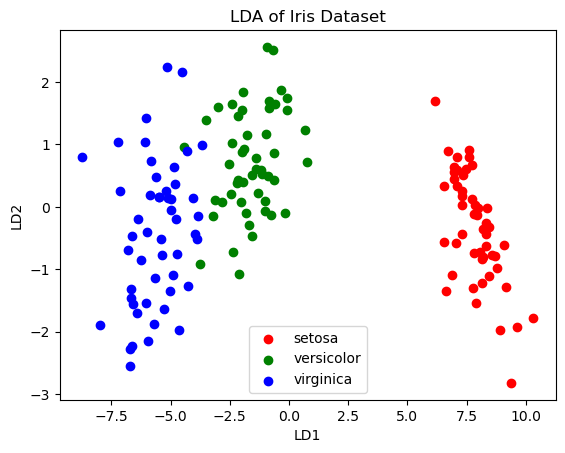

In [5]:
import matplotlib.pyplot as plt
# 使用LDA将数据降维到2维
X_lda = lda.transform(X)

# 为每种鸢尾花设置不同的颜色
colors = ['red', 'green', 'blue']
targets = [0, 1, 2]
labels = iris.target_names

# 绘制每种鸢尾花的散点图
for color, target, label in zip(colors, targets, labels):
    plt.scatter(X_lda[y == target, 0], X_lda[y == target, 1], c=color, label=label)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA of Iris Dataset')
plt.legend()
plt.show()

Method：然后我们写了自己的LDA方法。总的来说就是要实现计算特征向量、选择主成分、投影到主成分空间和分类四个功能。我们分别在方法中完善。我们使用课件上的公式计算特征值和特征向量，并直接选择了主成分；之后我们又使用内积的方法进行投影降维；在新的空间上，我们利用距离计算进行分类预测。以下是我们的代码和结果。

准确率: 0.9777777777777777


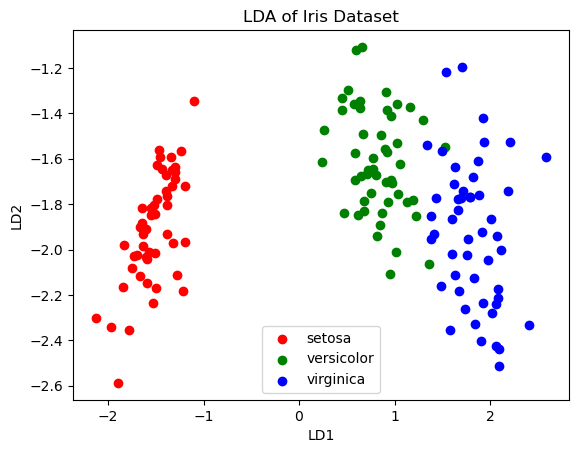

In [9]:
import numpy as np

# 加载鸢尾花数据集
iris = datasets.load_iris()
X = iris.data
y = iris.target

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # 计算所有类别的均值、整体均值和类内散度矩阵
        mean_overall = np.mean(X, axis=0)
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            S_W += (X_c - mean_c).T.dot(X_c - mean_c)
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            S_B += n_c * (mean_diff).dot(mean_diff.T)

        # 计算特征向量和特征值
        A = np.linalg.inv(S_W).dot(S_B)
        eigenvalues, eigenvectors = np.linalg.eig(A)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # 存储前n个特征向量
        self.linear_discriminants = eigenvectors[0:self.n_components]
        # 计算并存储每个类的中心
        self.class_means = {}
        for c in np.unique(y):
            X_c = self.transform(X[y == c])
            self.class_means[c] = np.mean(X_c, axis=0)

    def transform(self, X):
        # 数据投影
        return np.dot(X, self.linear_discriminants.T)
    def predict(self,X):
         # 将X投影到LDA特征空间
        X_projected = self.transform(X)

        # 进行分类：找到每个样本在LDA空间中最近的类中心
        predictions = []
        for x in X_projected:
            distances = [np.linalg.norm(x - mean) for mean in self.class_means.values()]
            class_prediction = np.argmin(distances)
            predictions.append(class_prediction)
        return np.array(predictions)


# 测试自定义LDA
lda0 = LDA(n_components=2)
lda0.fit(X_train, y_train)
# 预测测试集
y_pred = lda0.predict(X_test)
# 计算准确率
accuracy0 = accuracy_score(y_test, y_pred)
print("准确率:", accuracy0)

X_train_lda = lda0.transform(X_train)
X_test_lda = lda0.transform(X_test)

# 为每种鸢尾花设置不同的颜色
colors = ['red', 'green', 'blue']
targets = [0, 1, 2]
labels = iris.target_names

# 绘制每种鸢尾花的散点图
Xlda = lda0.transform(X)
for color, target, label in zip(colors, targets, labels):
    plt.scatter(Xlda[y == target, 0], Xlda[y == target, 1], c=color, label=label)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA of Iris Dataset')
plt.legend()
plt.show()


我们得到了一个与调包类似的结果，说明我们的方法是可行有效的。

Discussion & Result：LDA（线性判别分析）和PCA（主成分分析）是两种常用的数据降维技术，它们在机器学习和统计分析中有着广泛的应用。这两种方法虽然都是用于降维，但它们的目标和方法有所不同。首先目标上，PCA的主要目的是发现数据中的主要成分，也就是那些解释大部分数据变异的方向。它通过正交变换将原始数据转换为一组线性无关的变量，这些变量被称为主成分。PCA主要用于数据的压缩和去噪，它试图保留数据中的大部分变异。而LDA的目的是找到一个投影，使得不同类别的数据在这个新的维度上有最大的区分度。LDA是一种监督学习算法，它利用类别标签来找到最优的投影方向。LDA的主要目标是最大化不同类别间的距离同时最小化同一类别内的距离。方法上，PCA通过最大化数据的方差来找到新的轴，它不考虑数据的标签或类别。PCA的结果是一组正交的主成分，数据可以在这些主成分上投影，以减少维数。LDA则是以最大化类间差异和最小化类内差异为目标。它需要类别标签来指导降维过程，通过这种方式，LDA尝试保留类别之间最重要的轴。因为以上两点的不同，因此在应用场景上产生不同。PCA适用于无监督学习的场景，如数据压缩、特征提取、数据可视化等，特别是在没有类别标签的情况下，而LDA适合于监督学习的场景，如模式识别、分类任务等，特别是在需要利用类别信息来指导降维的场景。